# Arriving Passenger Darts Modeling

by yuki (initialized 7/19)

## Installing Darts

In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400 kB 29.9 MB/s 
     |████████████████████████████████| 793 kB 17.8 MB/s 
     |████████████████████████████████| 179 kB 67.5 MB/s 
     |████████████████████████████████| 9.8 MB 52.9 MB/s 
     |████████████████████████████████| 1.4 MB 57.0 MB/s 
     |████████████████████████████████| 11.2 MB 51.4 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 44 kB 2.6 MB/s 
     |████████████████████████████████| 585 kB 52.9 MB/s 
     |████████████████████████████████| 381 kB 25.5 MB/s 
     |████████████████████████████████| 944 kB 55.9 MB/s 
     |████████████████████████████████| 140 kB 47.4 MB/s 
     |████████████████████████████████| 419 kB 54.1 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.4 MB/s 
     |████████████████████████████

In [ ]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 37.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    AutoARIMA,
    VARIMA,
    ExponentialSmoothing,
    Theta
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.utils import SeasonalityMode

import sklearn
from sklearn.metrics import r2_score


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Checking Dataframe

In [ ]:
df = pd.read_csv('ArrPaxFinaldf.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head()

,TimeInterval,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
0,2021-03-13 00:00:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
1,2021-03-13 00:10:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
2,2021-03-13 00:20:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
3,2021-03-13 00:30:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
4,2021-03-13 00:40:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0


In [ ]:
df['TimeInterval'] = pd.to_datetime(df['TimeInterval'])
df.set_index('TimeInterval',inplace=True)

In [ ]:
df = df.asfreq('10T')
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
df.describe()

,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
count,42336.000000,42336.000000,42336.000000,42336.000000,42330.000000,42336.000000,42336.000000,4.233600e+04,42336.000000,42336.000000,42336.000000,42336.000000
mean,2.826531,23.988473,0.254614,1.298469,44.446208,8.710672,0.139456,3.586837e+08,2.229939,16.656107,11.118897,34.519480
std,0.986576,20.025184,0.366851,0.655248,22.063763,7.530635,0.346426,1.010667e+08,8.800598,63.064756,24.464704,73.953926
min,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.181093e+08,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.333333,0.000000,1.000000,27.666667,1.500000,0.000000,3.045942e+08,0.000000,0.000000,0.000000,0.000000
50%,3.000000,20.333333,0.000000,1.000000,46.333333,7.833333,0.000000,3.681045e+08,0.000000,0.000000,0.000000,0.000000
75%,4.000000,33.166667,0.333333,1.000000,60.666667,13.333333,0.000000,4.290358e+08,0.000000,0.000000,0.000000,0.000000
max,4.000000,154.333333,3.000000,4.000000,113.500000,43.166667,1.000000,5.306513e+08,148.217185,1096.071415,232.992257,589.333357


In [ ]:
df['Parking#'].fillna(0,inplace=True)

## Splitting and Scaling

In [ ]:
covariates = df[df.columns[~df.columns.isin(['AT_PAX','Taxi_PAX','Parking#','FHV#'])]]
targets = df[['AT_PAX','Parking#','FHV#']]

In [ ]:
cov = TimeSeries.from_dataframe(covariates,freq='10T')
tar = TimeSeries.from_dataframe(targets,freq='10T')

In [ ]:
#scaling

sc_cov = Scaler()
cov_sc = sc_cov.fit_transform(cov)

sc_tar = Scaler()
tar_sc = sc_tar.fit_transform(tar)

In [ ]:
cov_train, cov_test = cov_sc.split_before(pd.Timestamp(2021,12,1))
tar_train, tar_test = tar_sc.split_before(pd.Timestamp(2021,12,1))

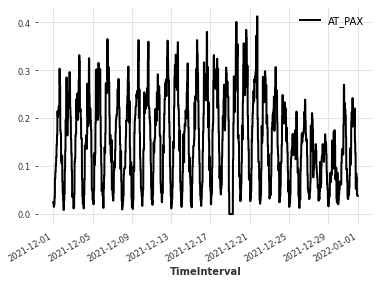

In [ ]:
tar_test['AT_PAX'].plot()

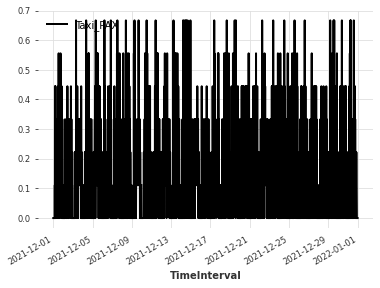

In [ ]:
tar_test['Taxi_PAX'].plot()

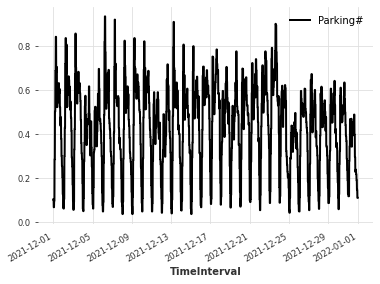

In [ ]:
tar_test['Parking#'].plot()

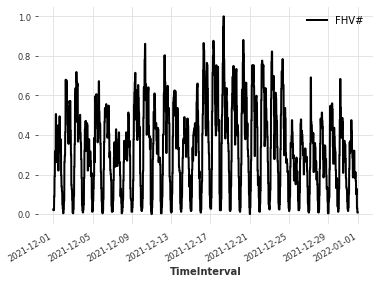

In [ ]:
tar_test['FHV#'].plot()

## Model Fitting RNN/LSTM

In [ ]:
len(tar_train)+len(cov_test)

42336

In [ ]:
from darts.utils.likelihood_models import LaplaceLikelihood

In [ ]:
my_model = RNNModel(
    model="LSTM",
    n_epochs=2,
    model_name="Arr_RNN",
    training_length=32,
    input_chunk_length=144,
    output_chunk_length=6,
    hidden_dim = 25,
    n_rnn_layers=4,
    optimizer_kwargs={'lr':.001},
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.01)
)

In [ ]:
my_model.fit(
    series=tar_train,
    future_covariates= cov_sc,
    verbose=True,
)

2022-07-21 00:07:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 37840 samples.
2022-07-21 00:07:57 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-21 00:07:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-07-21 00:07:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-21 00:07:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-21 00:07:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
2022-07-21 00:07:57 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Pa

Training: 0it [00:00, ?it/s]

In [ ]:
len(tar_train)

37872

In [ ]:
pred = my_model.predict(len(tar_test), series=tar_train, future_covariates=cov_sc)

Predicting: 1183it [00:00, ?it/s]

In [ ]:
pred

<TimeSeries (DataArray) (TimeInterval: 4464, component: 4, sample: 1)>
array([[[ 0.02347749],
        [ 0.0196034 ],
        [ 0.0962106 ],
        [ 0.00510354]],

       [[ 0.02136145],
        [ 0.00859338],
        [ 0.10592211],
        [ 0.02622619]],

       [[ 0.0187584 ],
        [-0.003342  ],
        [ 0.14399258],
        [-0.01441203]],

       ...,

       [[ 0.11577593],
        [ 0.03488511],
        [ 0.59502567],
        [ 0.02297851]],

       [[ 0.07766331],
        [ 0.01843516],
        [ 0.62735174],
        [ 0.06362324]],

       [[ 0.06868067],
        [-0.00179109],
        [ 0.59217494],
        [ 0.18923877]]])
Coordinates:
  * TimeInterval  (TimeInterval) datetime64[ns] 2021-12-01 ... 2021-12-31T23:...
  * component     (component) object 'AT_PAX' 'Taxi_PAX' 'Parking#' 'FHV#'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

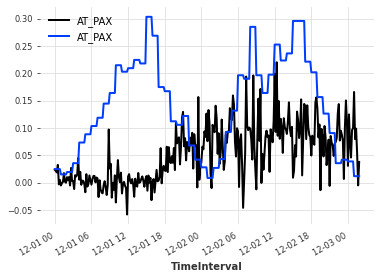

In [ ]:
pred['AT_PAX'][:300].plot()
tar_test['AT_PAX'][:300].plot()

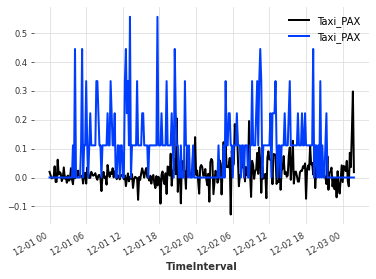

In [ ]:
pred['Taxi_PAX'][:300].plot()
tar_test['Taxi_PAX'][:300].plot()

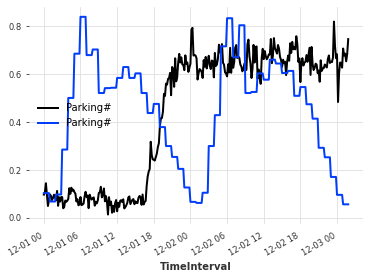

In [ ]:
pred['Parking#'][:300].plot()
tar_test['Parking#'][:300].plot()

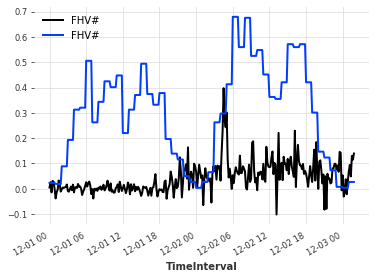

In [ ]:
pred['FHV#'][:300].plot()
tar_test['FHV#'][:300].plot()

In [ ]:
from darts.models import RegressionModel

In [ ]:
regr_model = RegressionModel(lags=None,
                           #   lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates = (4,30))

regr_model.fit(tar_train ,
            #    past_covariates=melting,
               future_covariates=cov_sc)

In [ ]:
pred = regr_model.predict(n=3000)

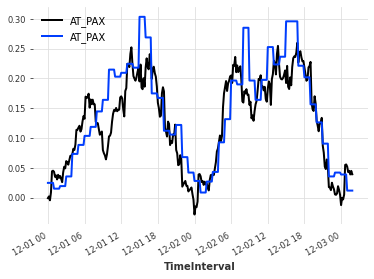

In [ ]:
pred['AT_PAX'][:300].plot()
tar_test['AT_PAX'][:300].plot()

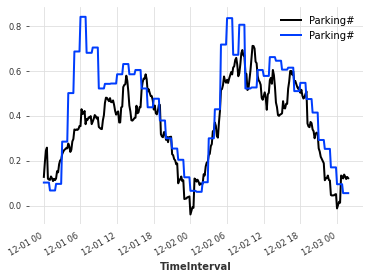

In [ ]:
pred['Parking#'][:300].plot()
tar_test['Parking#'][:300].plot()

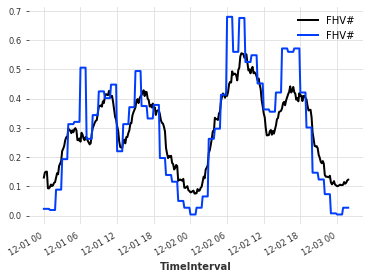

In [ ]:
pred['FHV#'][:300].plot()
tar_test['FHV#'][:300].plot()

<AxesSubplot:xlabel='TimeInterval'>

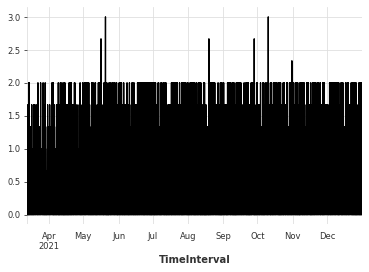

In [ ]:
df['Taxi_PAX'].plot()

In [ ]:
df.describe()

,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
count,42336.000000,42336.000000,42336.000000,42336.000000,42336.000000,42336.000000,42336.000000,4.233600e+04,42336.000000,42336.000000,42336.000000,42336.000000
mean,2.826531,23.988473,0.254614,1.298469,44.439909,8.710672,0.139456,3.586837e+08,2.229939,16.656107,11.118897,34.519480
std,0.986576,20.025184,0.366851,0.655248,22.068543,7.530635,0.346426,1.010667e+08,8.800598,63.064756,24.464704,73.953926
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.181093e+08,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.333333,0.000000,1.000000,27.666667,1.500000,0.000000,3.045942e+08,0.000000,0.000000,0.000000,0.000000
50%,3.000000,20.333333,0.000000,1.000000,46.333333,7.833333,0.000000,3.681045e+08,0.000000,0.000000,0.000000,0.000000
75%,4.000000,33.166667,0.333333,1.000000,60.666667,13.333333,0.000000,4.290358e+08,0.000000,0.000000,0.000000,0.000000
max,4.000000,154.333333,3.000000,4.000000,113.500000,43.166667,1.000000,5.306513e+08,148.217185,1096.071415,232.992257,589.333357


In [ ]:
from darts.metrics import rmse

In [ ]:

print(r2_score(tar_test[:3000].pd_dataframe(),pred.pd_dataframe())) 

0.5814935856206761


In [ ]:
def plot_agg_result(actual, pred,frequency,start_date,end_date):

    test_df = actual.pd_dataframe()
    test_df = pd.merge(test_df, pred.pd_dataframe(), how='right',left_index=True, right_index=True)

    
    test_df = test_df.reset_index()
    test_df = test_df.groupby(pd.Grouper(key="TimeInterval", freq=frequency)).sum()

    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    print(r2_score(test_df.iloc[:,0],test_df.iloc[:,1]))
    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),:].plot()

0.5655678771037831


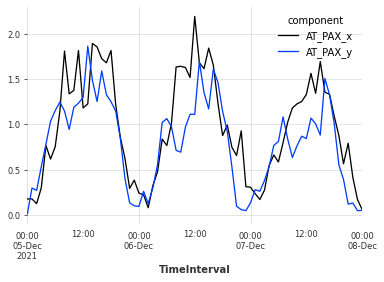

In [ ]:
plot_agg_result(tar_test[:3000]['AT_PAX'],pred['AT_PAX'],'1H','2021-12-05','2021-12-08')

0.7307565452029089


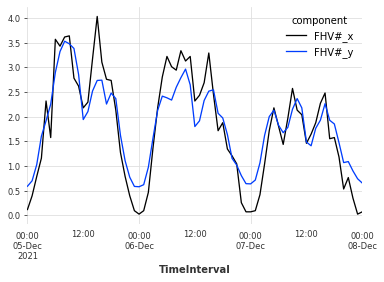

In [ ]:
plot_agg_result(tar_test[:3000]['FHV#'],pred['FHV#'],'1H','2021-12-05','2021-12-08')

0.5087368320426


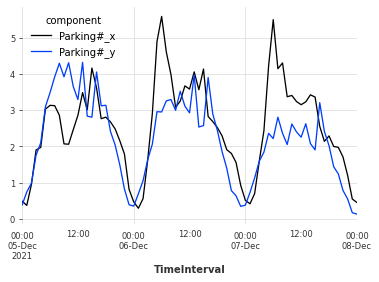

In [ ]:
plot_agg_result(tar_test[:3000]['Parking#'],pred['Parking#'],'1H','2021-12-05','2021-12-08')